In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from dca_research.lqg import LQGComponentsAnalysis as LQGCA
import matplotlib.pyplot as plt
import sys
import pickle
import pandas as pd
from tqdm import tqdm
import scipy

In [3]:
sys.path.append('/home/akumar/nse/neural_control')

In [4]:
from loaders import load_cv
from utils import apply_df_filters

### Claim 1: PCA can outdo FCCA at LQG Score. Initializing from PCA leads to only marginal improvements

In [5]:
# CV
with open('/mnt/Secondary/data/postprocessed/cv_highd_df.dat', 'rb') as f:
    cv_df = pickle.load(f)
cv_df = pd.DataFrame(cv_df)

In [6]:
# Wtf is going on with CV dataset
dat = load_cv('/mnt/Secondary/data/cv/EC2_hg.h5')
X = np.squeeze(dat['spike_rates'])

In [8]:
# What is the fraction of the asymptotic LQR cost attained?
dimvals = np.unique(cv_df['dim'].values)
data_files = np.unique(cv_df['data_file'].values)

fcca_scoresc = np.zeros((dimvals.size, data_files.size, 2))
pca_scoresc = np.zeros((dimvals.size, data_files.size, 2))

for i, data_file in enumerate(data_files):
    dat = load_cv('/mnt/Secondary/data/cv/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])

    Xp = np.reshape(X, (-1, X.shape[-1]))
    pcamodel = PCA().fit(Xp)
    pca_ambient = np.sum(pcamodel.explained_variance_)
    for j, d in tqdm(enumerate(dimvals)):
        # df = apply_df_filters(cv_df, data_file=data_file, dimreduc_method='LQGCA', dim=d)
        # assert(df.shape[0] == 1)

        lqgmodel = LQGCA(T=4, n_init=20, d=d)
        #lqgscore = lqgmodel.score(X=X, coef=df.iloc[0]['coef'])
        lqgmodel.fit(X)

        fcca_scoresc[j, i, 0] = np.max(lqgmodel.scores)
        lqgscore = lqgmodel.score(X=X, coef=pcamodel.components_.T[:, 0:d])
        fcca_scoresc[j, i, 1] = lqgscore

        pca_scoresc[j, i, 0] = np.sum(pcamodel.explained_variance_ratio_[0:d])

        if d > 1:*
            pca_scoresc[j, i, 1] = np.trace(np.cov(Xp @ lqgmodel.coef_, rowvar=False))/pca_ambient
        else:
            pca_scoresc[j, i, 1] = np.var(Xp @ lqgmodel.coef_)/pca_ambient

16it [03:52, 14.52s/it]
16it [05:10, 19.39s/it]


Text(0.5, 0, 'Dimension')

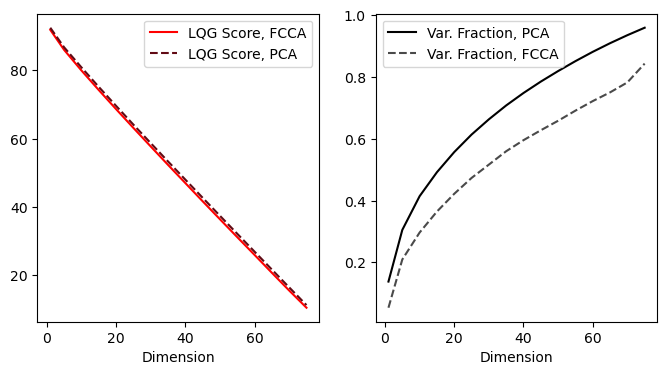

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(dimvals, -1*fcca_scoresc[:, 0, 0], 'r')
ax[0].plot(dimvals, fcca_scoresc[:, 0, 1], '#610a14', linestyle='dashed')
ax[0].legend(['LQG Score, FCCA', 'LQG Score, PCA'])
ax[1].plot(dimvals, pca_scoresc[:, 0, 0], 'k')
ax[1].plot(dimvals, pca_scoresc[:, 0, 1], '#4a4a4a', linestyle='dashed')
ax[1].legend(['Var. Fraction, PCA', 'Var. Fraction, FCCA'])

ax[0].set_xlabel('Dimension')
ax[1].set_xlabel('Dimension')

In [ ]:
# Subspace angles, d=6 

In [26]:
import pdb

In [28]:
ssa1 = np.zeros((len(data_files), 20, 20, 6))
scores = np.zeros((len(data_files), 20))
ssa2 = np.zeros((len(data_files), 20, 6))

for i, data_file in enumerate(data_files):
    dat = load_cv('/mnt/Secondary/data/cv/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])

    Xp = np.reshape(X, (-1, X.shape[-1]))
    pcamodel = PCA().fit(Xp)
    pca_ambient = np.sum(pcamodel.explained_variance_)
    coef = []

    for rep1 in tqdm(range(20)):

        lqgmodel1 = LQGCA(T=4, n_init=1, d=6, rng_or_seed=rep1)
        #lqgscore = lqgmodel.score(X=X, coef=df.iloc[0]['coef'])
        lqgmodel1.fit(X)
        scores[i, rep1] = -1*np.max(lqgmodel1.scores)

        coef.append(lqgmodel1.coef_)

        ssa2[i, rep1, :] = scipy.linalg.subspace_angles(lqgmodel1.coef_, pcamodel.components_.T[:, 0:6])

    for rep1 in range(20):
        for rep2 in range(20):
            ssa1[i, rep1, rep2, :] = scipy.linalg.subspace_angles(coef[rep1], coef[rep2])


100%|██████████| 20/20 [00:40<00:00,  2.03s/it]


(array([1., 0., 2., 3., 6., 2., 2., 2., 1., 1.]),
 array([0.57724825, 0.58223256, 0.58721686, 0.59220116, 0.59718547,
        0.60216977, 0.60715407, 0.61213838, 0.61712268, 0.62210698,
        0.62709129]),
 <BarContainer object of 10 artists>)

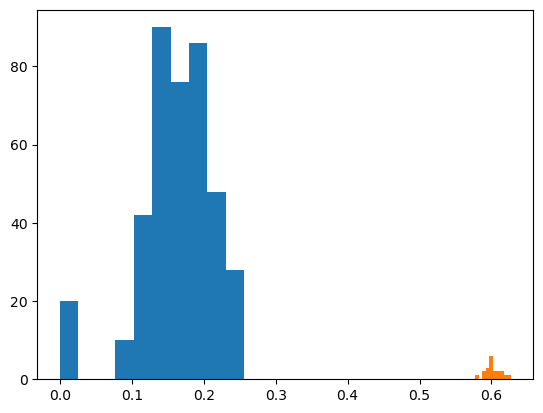

In [31]:
plt.hist(np.mean(ssa1[0, ...], axis=-1).ravel())
plt.hist(np.mean(ssa2[0, ...], axis=-1).ravel())

In [32]:
# Initializing from PCA. Keep track of subspace angle
ssa3 = np.zeros((len(data_files), 20, 6))

for i, data_file in enumerate(data_files):
    dat = load_cv('/mnt/Secondary/data/cv/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])

    Xp = np.reshape(X, (-1, X.shape[-1]))
    pcamodel = PCA().fit(Xp)
    pca_ambient = np.sum(pcamodel.explained_variance_)
    coef = []

    for rep1 in tqdm(range(20)):

        lqgmodel1 = LQGCA(T=4, n_init=1, d=6, init=pcamodel.components_.T[:, 0:6])
        #lqgscore = lqgmodel.score(X=X, coef=df.iloc[0]['coef'])
        lqgmodel1.fit(X)
        coef.append(lqgmodel1.coef_)

        ssa3[i, rep1, :] = scipy.linalg.subspace_angles(lqgmodel1.coef_, pcamodel.components_.T[:, 0:6])


100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


(array([ 0.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  0.]),
 array([0.08195558, 0.18195558, 0.28195558, 0.38195558, 0.48195558,
        0.58195558, 0.68195558, 0.78195558, 0.88195558, 0.98195558,
        1.08195558]),
 <BarContainer object of 10 artists>)

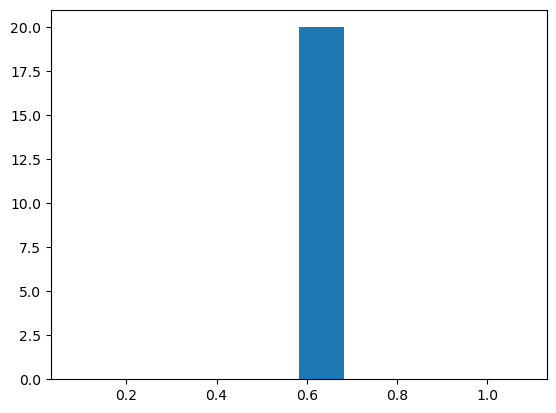

In [33]:
plt.hist(np.mean(ssa3[0, ...], axis=-1).ravel())

In [ ]:
# Show this continues to hold true, at fixed dimensionality, for T = 10, 20, 40

In [35]:
dimvals = np.unique(cv_df['dim'].values)
data_files = np.array([np.unique(cv_df['data_file'].values)[0]])
T = [10, 20, 40]
fcca_scoresc2 = np.zeros((len(T), data_files.size, 2))
ssa4 = np.zeros((len(T), data_files.size, 6))
for i, data_file in enumerate(data_files):
    dat = load_cv('/mnt/Secondary/data/cv/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])

    Xp = np.reshape(X, (-1, X.shape[-1]))
    pcamodel = PCA().fit(Xp)
    pca_ambient = np.sum(pcamodel.explained_variance_)
    for j, t in tqdm(enumerate(T)):
        # df = apply_df_filters(cv_df, data_file=data_file, dimreduc_method='LQGCA', dim=d)
        # assert(df.shape[0] == 1)

        lqgmodel = LQGCA(T=t, n_init=20, d=6)
        lqgmodel.fit(X)

        fcca_scoresc2[j, i, 0] = np.max(lqgmodel.scores)
        lqgscore = lqgmodel.score(X=X, coef=pcamodel.components_.T[:, 0:6])
        fcca_scoresc2[j, i, 1] = lqgscore

        ssa4[j, i, :] = scipy.linalg.subspace_angles(lqgmodel.coef_, pcamodel.components_.T[:, 0:6])

3it [10:12, 204.21s/it]


In [36]:
fcca_scoresc2

array([[[ -134.67957861,     0.        ]],

       [[ -382.91547961,     0.        ]],

       [[-1647.11812352,     0.        ]]])

In [37]:
ssa4[:, 0, :]

array([[0.78811607, 0.36625086, 0.2611997 , 0.20291845, 0.15133062,
        0.06984185],
       [0.39855406, 0.30558594, 0.21056277, 0.15474795, 0.09960947,
        0.05538711],
       [0.3521828 , 0.29522522, 0.22834849, 0.13958443, 0.10273689,
        0.05634312]])

In [38]:
# Implications for decoding

In [41]:
from sklearn.model_selection import StratifiedKFold
import h5py

In [42]:
fname = '/mnt/Secondary/data/cv/EC2_hg.h5'
with h5py.File(fname, 'r') as f:
    X = np.squeeze(f['X'][:])
    y = f['y'][:]
n_trials, n_time, n_ch = X.shape
cvs = np.unique(y)

In [43]:
null_accuracy = np.zeros((10, 1, 2))

trte = StratifiedKFold(n_splits=10, shuffle=True, random_state=20200831)

for ii, (train_idx, test_idx) in enumerate(trte.split(X, y)):
    Xtrain = X[train_idx]
    ytrain = y[train_idx]
    Xtest = X[test_idx]
    ytest = y[test_idx]
    options, counts = np.unique(ytrain, return_counts=True)
    guess = options[counts.argmax()]
    print(guess)
    null_accuracy[ii, 0, 0] = (ytrain == guess).mean()
    null_accuracy[ii, 0, 1] = (ytest == guess).mean()

b'yoo'
b'yoo'
b'yoo'
b'yoo'
b'yoo'
b'yoo'
b'yoo'
b'yoo'
b'yoo'
b'yoo'


In [44]:
T = np.array([4, 10, 20, 40])[::-1]
dims = np.concatenate([np.arange(1, 7), np.arange(7, 14, 2), [20, 25, 30]])
print(dims)
accuracy = np.zeros((2, 10, dims.size, 2))

trte = StratifiedKFold(n_splits=10, shuffle=True, random_state=20200831)

for ii, (train_idx, test_idx) in enumerate(trte.split(X, y)):
    Xtrain = X[train_idx]
    ytrain = y[train_idx]
    Xtest = X[test_idx]
    ytest = y[test_idx]
    # dca_model = DCA(T=T, d=dims.max())
    # dca_model.estimate_data_statistics(Xtrain)
    lqg_model = LQGCA(T=40, d=dims.max())
    lqg_model.estimate_data_statistics(Xtrain)
    for jj, d in enumerate(dims):
        print(ii, (jj, d))
        pca_model = PCA(d)
        Xtrain_pca = pca_model.fit_transform(Xtrain.reshape(Xtrain.shape[0], -1))
        Xtest_pca = pca_model.transform(Xtest.reshape(Xtest.shape[0], -1))
        lr_model = LogisticRegressionCV(cv=5, multi_class='multinomial', max_iter=500)
        lr_model.fit(Xtrain_pca, ytrain)
        accuracy[0, ii, jj, 0] = lr_model.score(Xtrain_pca, ytrain)
        accuracy[0, ii, jj, 1] = lr_model.score(Xtest_pca, ytest)
        
        lqg_model.fit_projection(d=d, n_init=20)
        
        Xtrain_dca = lqg_model.transform(Xtrain).reshape(Xtrain.shape[0], -1)

        Xtest_dca = lqg_model.transform(Xtest).reshape(Xtest.shape[0], -1)
        lr_model = LogisticRegressionCV(cv=5, multi_class='multinomial', max_iter=500)
        lr_model.fit(Xtrain_dca, ytrain)
        accuracy[1, ii, jj, 0] = lr_model.score(Xtrain_dca, ytrain)
        accuracy[1, ii, jj, 1] = lr_model.score(Xtest_dca, ytest)

[ 1  2  3  4  5  6  7  9 11 13 20 25 30]
0 (0, 1)


NameError: name 'LogisticRegressionCV' is not defined